<a href="https://colab.research.google.com/github/joser834/Data-Science/blob/master/Convnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount = True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [2]:
#For data processing, operations, structures, and encoding
import numpy as np
import pandas as pd
import time
from datetime import datetime
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

#For Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#For deep learning
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import optimizers

#For hidden representations
import cv2
from IPython.display import Image

Using TensorFlow backend.


In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Importing Data

In [0]:
path = '/content/drive/My Drive/2019/Galileo/3er Trimestre/Deep Learning/Convnet/'

In [0]:
df_raw = pd.read_csv(path + 'digit-recognizer/train.csv')

## 1. Feature Engineering

In [6]:
print('Shape of complete data set:', df_raw.shape)

Shape of complete data set: (42000, 785)


#### Reshaping the sets to become 28x28 images

In [0]:
X = df_raw.drop('label', axis = 1).values.reshape((df_raw.shape[0],28,28,1))
y = df_raw['label']

In [8]:
print('Shape of X:', X.shape)
print('Shape of y (labels):', y.shape)

Shape of X: (42000, 28, 28, 1)
Shape of y (labels): (42000,)


### Normalizing the data set

In [0]:
X = X/255
y = y

## 2. Train, Val, and Test Split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

print('X train shape:', X_train.shape)
print('y train shape:', y_train.shape)
print('X validation shape:', X_val.shape)
print('y validation shape:', y_val.shape)
print('X test shape:', X_test.shape)
print('y test shape:', y_test.shape)

X train shape: (33600, 28, 28, 1)
y train shape: (33600,)
X validation shape: (4200, 28, 28, 1)
y validation shape: (4200,)
X test shape: (4200, 28, 28, 1)
y test shape: (4200,)


In [0]:
def convnet(epochs, lr, batch, architecture, x_model, y_model, x_val, y_val):
  
  callbacks = [EarlyStopping(monitor='val_loss', patience=2),
               ModelCheckpoint((path+'model/weights_checkpoints.h5'), save_best_only=True, save_weights_only=False)]
  
  #Defining the model
  model = Sequential()
  
  #Architecture
  for i in range(len(architecture['layers'])):
    if i == len(architecture['layers']):
      model.add(
        Conv2D(
            filters = architecture['layers'][i], 
            kernel_size = architecture['kernel_size'][i], 
            activation = architecture['activation'][i]
        )
      )
    else:
      model.add(
          Conv2D(
              filters = architecture['layers'][i], 
              kernel_size = architecture['kernel_size'][i], 
              activation = architecture['activation'][i],
              input_shape = (x_model.shape[1], x_model.shape[2], x_model.shape[3])
          )
      )
    model.add(
        MaxPooling2D(
            pool_size = (2,2)
        )
    )
  model.add(Flatten())
  model.add(Dense(10, activation = 'softmax'))
  opt = Adam(lr=lr, beta_1=0.9, beta_2=0.999, amsgrad=False)
  model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])
  model.summary()
  
  #Training the model
  history = model.fit(
      x_model, 
      y_model, 
      epochs=epochs, 
      batch_size=batch, 
      validation_data=(x_val, y_val), 
      callbacks=callbacks, 
      verbose=2, 
      shuffle=False
  )
  
  return(model, history)

In [0]:
arch = {
    'layers': [64,32],
    'kernel_size': [3,3],
    'activation': ['relu', 'relu']
}

In [13]:
m, h = convnet(
    epochs = 30,
    lr = 0.0001,
    batch = 64,
    architecture = arch,
    x_model = X_train,
    y_model = y_train,
    x_val = X_val,
    y_val = y_val
)







Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                8010      
Total params: 27,114
Trainable params: 27,114
Non-trainable params: 0
____________________________________________

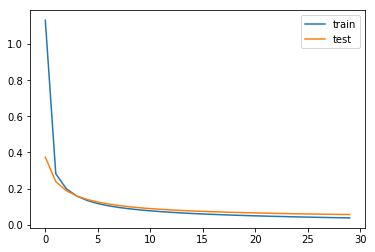

In [14]:
plt.plot(h.history['loss'], label='train')
plt.plot(h.history['val_loss'], label='test')
plt.legend()

As we can see, we have an accuracy of 98.12% over the validation dataset, which is very high.

## Hidden Representations and Results

In [0]:
layer_outputs = [layer.output for layer in m.layers[:6]]
activation_model = Model(inputs=m.input, outputs=layer_outputs)

In [16]:
activation_model

In [0]:
def hidden(act, layer):
  hidden_layer = act[layer]
  channels = hidden_layer.shape[3]
  print(channels)
  print('Hidden layer', layer, 'representation')
  for i in range(channels):
    plt.matshow(hidden_layer[0, :, :, i], cmap='viridis')
  plt.close()

In [106]:
img = X_test[123]
activations = activation_model.predict(img.reshape(1,28,28,1))
print('Original image shape:', img.shape)
cv2.imwrite('/content/drive/My Drive/2019/Galileo/3er Trimestre/Deep Learning/Convnet/test.jpg', img*255)
print('Original Image')
Image('/content/drive/My Drive/2019/Galileo/3er Trimestre/Deep Learning/Convnet/test.jpg')

Original image shape: (28, 28, 1)
Original Image


### Hidden Layer #0 Representation with test image

64
Hidden layer 0 representation


/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


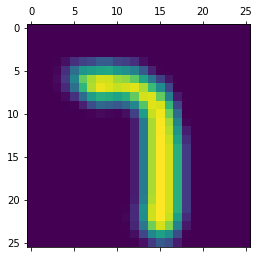

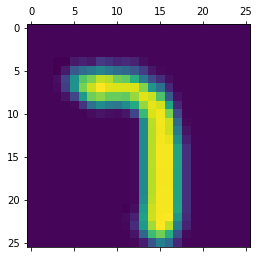

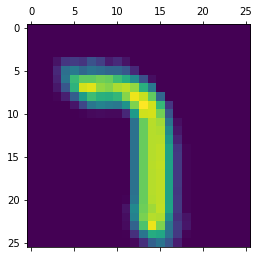

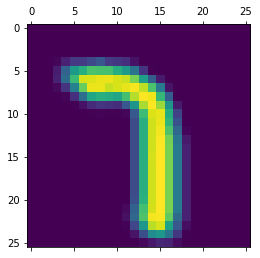

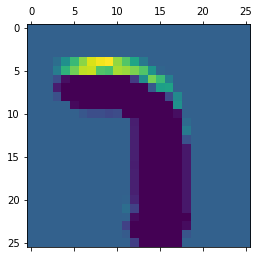

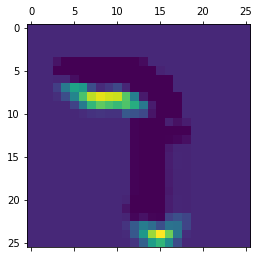

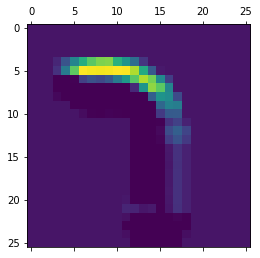

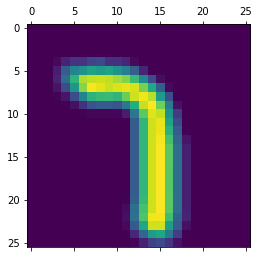

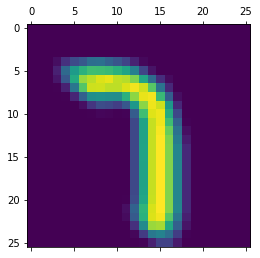

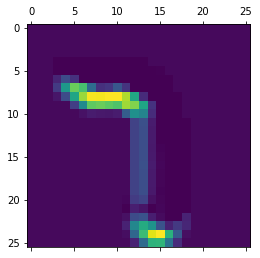

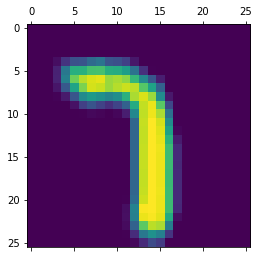

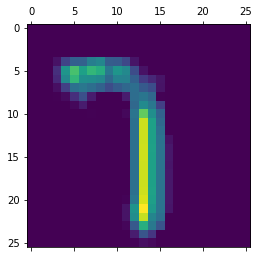

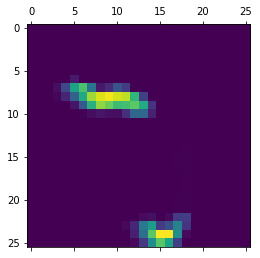

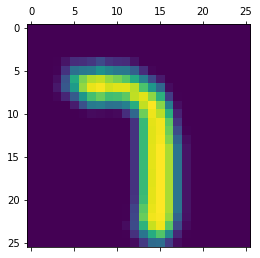

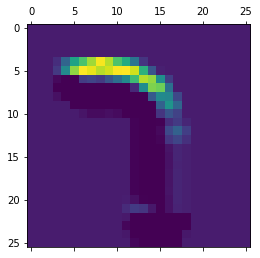

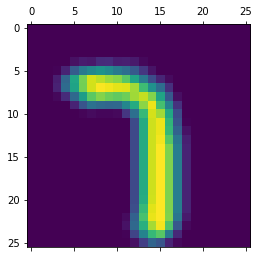

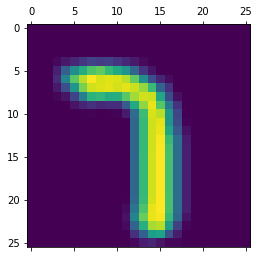

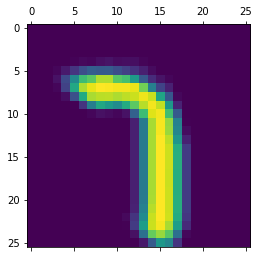

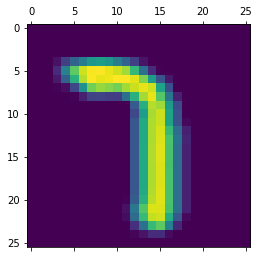

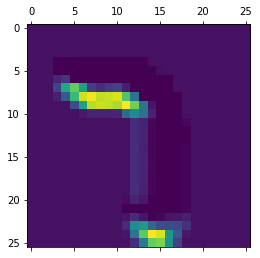

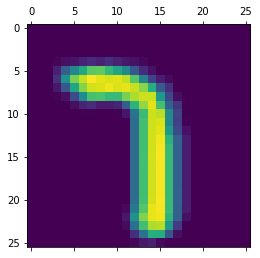

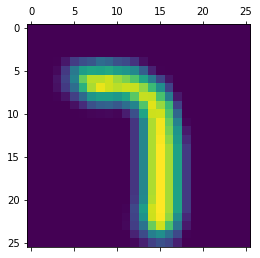

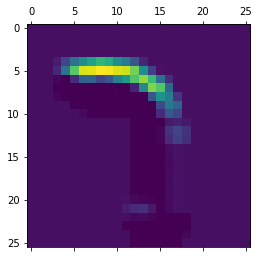

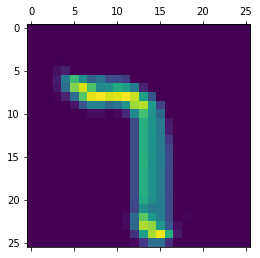

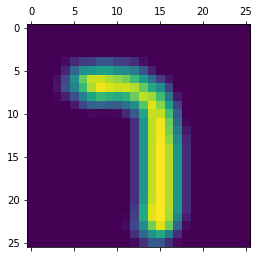

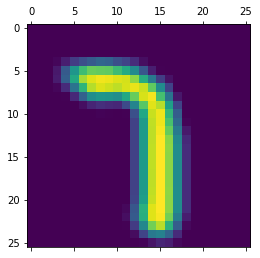

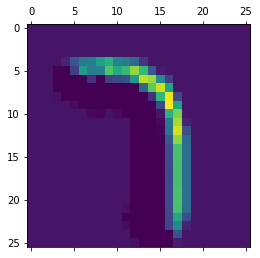

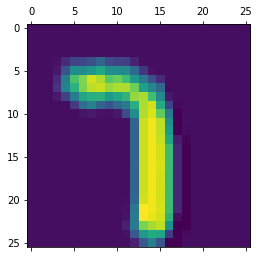

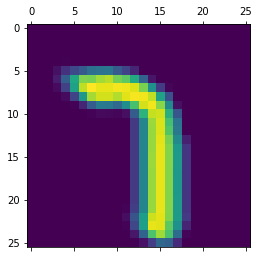

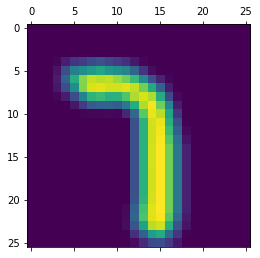

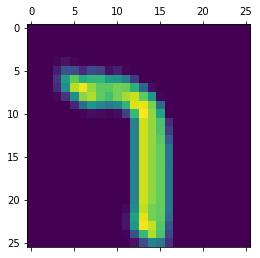

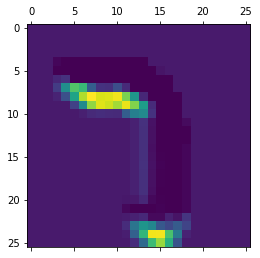

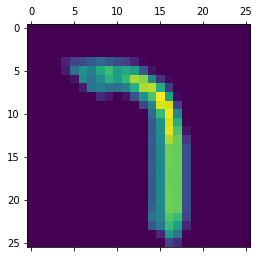

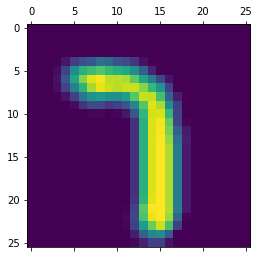

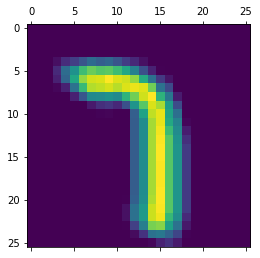

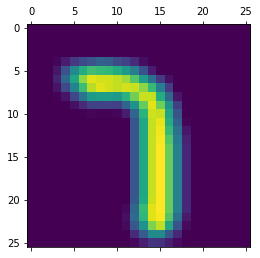

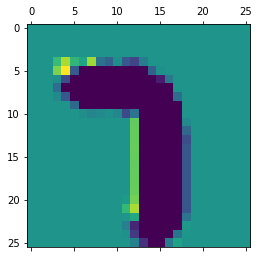

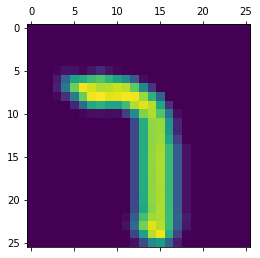

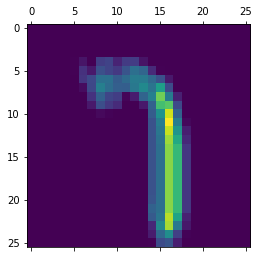

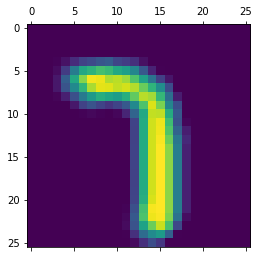

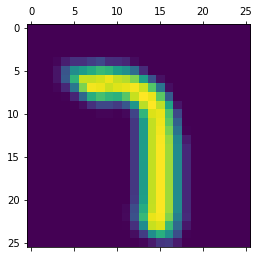

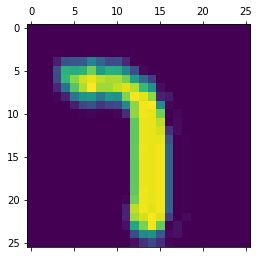

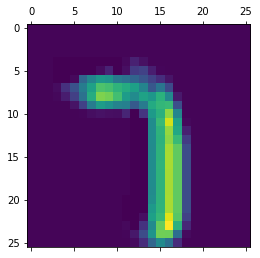

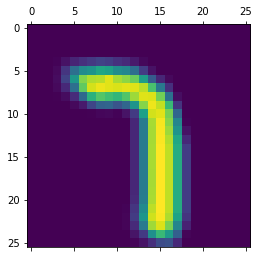

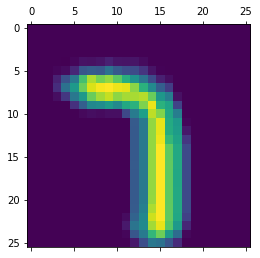

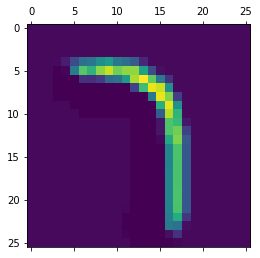

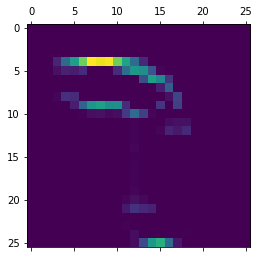

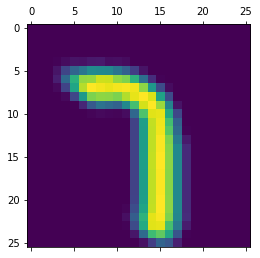

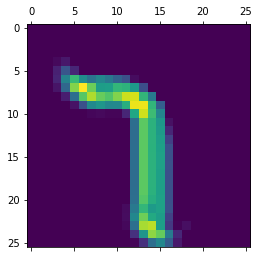

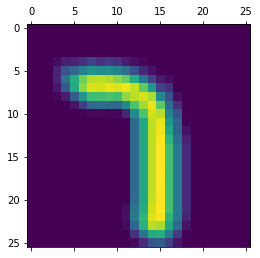

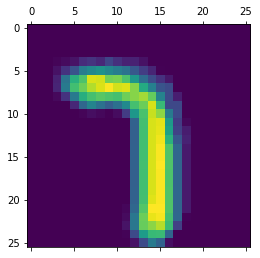

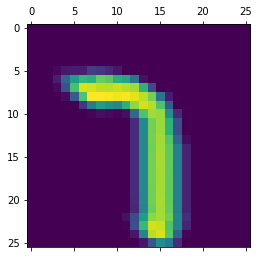

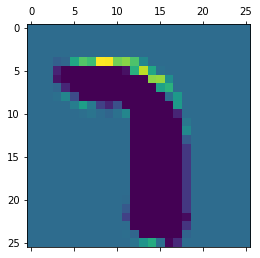

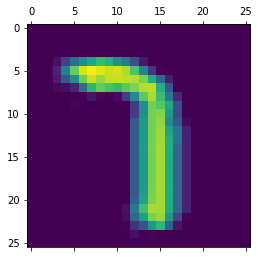

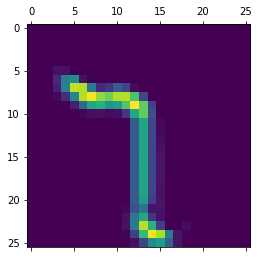

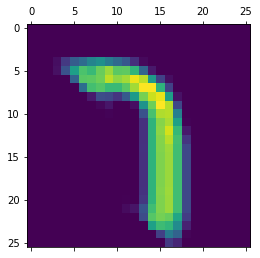

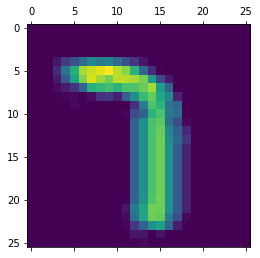

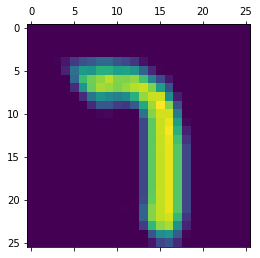

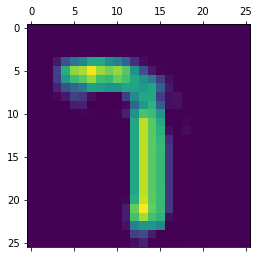

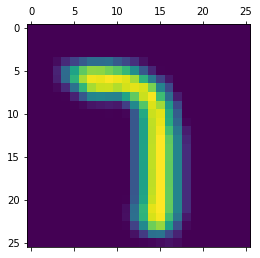

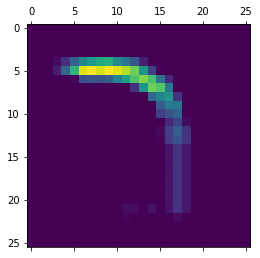

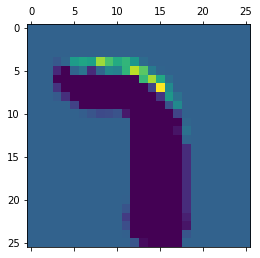

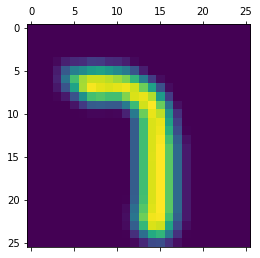

In [107]:
hidden(activations, 0)

## Final Result for a test example

In [108]:
m.predict_classes(img.reshape((1,28,28,1)))

array([7])

We can see that the test was predicted successfully as the number 7.